In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import optuna
import time

In [9]:
start=time.time()
from module.preprocess import preprocess_data

csv_path = 'newdata.csv'
features, target = preprocess_data(csv_path)
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, shuffle=False)

class SolarDataset(Dataset):
    """
    A PyTorch Dataset for loading solar power generation data.

    Parameters
    ----------
    features : numpy.ndarray
        The input features for the model.
    labels : numpy.ndarray
        The labels corresponding to the input features.
    sequence_length : int
        The length of the sequence to be used for each data point.

    Attributes
    ----------
    features : list
        List of input features, segmented into sequences.
    labels : numpy.ndarray
        Array of labels corresponding to the sequences in `features`.
    """
    def __init__(self, features, labels, sequence_length=20):
        self.features = [features[i: i+sequence_length] for i in range(len(features)-sequence_length+1)]
        self.labels = labels[sequence_length-1:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor([self.labels[idx]])

train_dataset = SolarDataset(X_train, y_train)
val_dataset = SolarDataset(X_val, y_val)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

class ConvLSTM(nn.Module):
    """
    A Convolutional LSTM model for time-series prediction.

    Parameters
    ----------
    input_size : int
        The number of input features per time step.
    num_filters : int
        The number of filters in the convolutional layer.
    kernel_size : int
        The size of the kernel in the convolutional layer.
    hidden_dim : int
        The dimensionality of the hidden state in the LSTM.
    num_layers : int
        The number of layers in the LSTM.
    dropout : float
        The dropout rate in the LSTM.

    Attributes
    ----------
    cnn : nn.Conv1d
        The convolutional layer.
    lstm : nn.LSTM
        The LSTM layer.
    fc : nn.Linear
        The linear layer that outputs the prediction.
    """
    def __init__(self, input_size, num_filters, kernel_size, hidden_dim, num_layers, dropout=0.3):
        super(ConvLSTM, self).__init__()

        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Convert (batch_size, seq_length, n) to (batch_size, n, seq_length) for CNN
        x = x.transpose(1, 2)
        c_out = self.cnn(x)
        # Transpose to (batch_size, seq_length, num_filters) for LSTM
        c_out = c_out.transpose(1, 2)

        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(device)

        lstm_out, _ = self.lstm(c_out, (h0, c0))
        y_pred = self.fc(lstm_out[:, -1, :])
        return y_pred

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvLSTM(input_size=X_train.shape[1], num_filters=64, kernel_size=3, hidden_dim=128, num_layers=2)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

num_epochs = 400
train_losses = []
val_losses = []

#training neural network
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    #validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(math.sqrt(train_loss))
    val_losses.append(math.sqrt(val_loss))
    scheduler.step(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {math.sqrt(train_loss)}, Validation Loss: {math.sqrt(val_loss)}')
end = time.time()
print(end-start)

Epoch: 1, Training Loss: 2090.7268176402195, Validation Loss: 2051.4105395100473
Epoch: 2, Training Loss: 2073.0439657662837, Validation Loss: 2034.9555634365313
Epoch: 3, Training Loss: 2057.298642880999, Validation Loss: 2018.9076014582258
Epoch: 4, Training Loss: 2041.421549313125, Validation Loss: 2003.0175743676855
Epoch: 5, Training Loss: 2025.5946741636146, Validation Loss: 1986.913179751689
Epoch: 6, Training Loss: 2009.754701947479, Validation Loss: 1971.0244838989272
Epoch: 7, Training Loss: 1994.139565326359, Validation Loss: 1955.2591672947917
Epoch: 8, Training Loss: 1978.6070883325976, Validation Loss: 1939.5771508742694
Epoch: 9, Training Loss: 1963.2332999417058, Validation Loss: 1923.9671003491214
Epoch: 10, Training Loss: 1947.8900497718037, Validation Loss: 1908.4244050203872
Epoch: 11, Training Loss: 1932.2438096679207, Validation Loss: 1892.926787432796
Epoch: 12, Training Loss: 1917.2463514113151, Validation Loss: 1877.5078540276427
Epoch: 13, Training Loss: 1901.

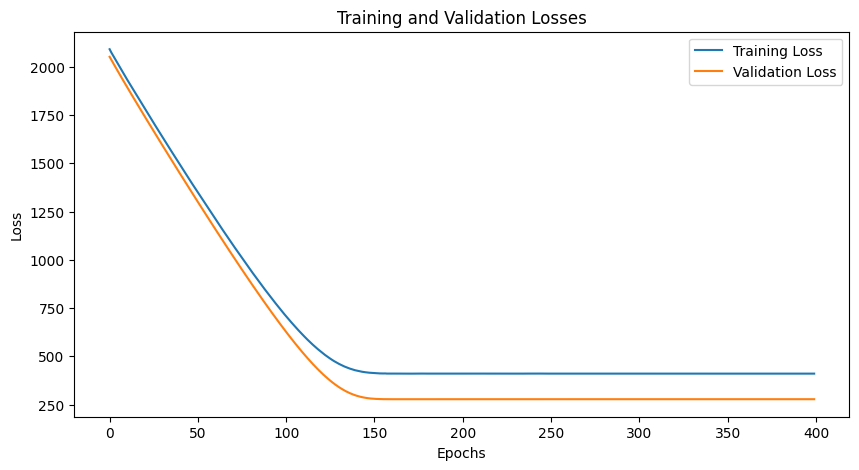

In [8]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()